In [2]:
from keras import Input, Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout, BatchNormalization, LeakyReLU
from keras.utils.vis_utils import plot_model

## Parent Sequence Encoder

In [4]:
par_inputs = Input(shape = (None,))
enc_embedding = Embedding(4500, 250)

par_inputs_emb = enc_embedding(par_inputs)
enc_BiLSTM = Bidirectional(LSTM(128, return_state = True))
enc_outputs, fwd_hPar, fwd_cPar, bwd_hPar, bwd_cPar = enc_BiLSTM(par_inputs_emb)
state_hPar = Concatenate()([fwd_hPar, bwd_hPar])
state_cPar= Concatenate()([fwd_cPar, bwd_cPar])
encoder_statePar = [state_hPar, state_cPar]
ParEncoder_model = Model([par_inputs], encoder_statePar)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 250)    1125000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 256), (None, 388096      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 256)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

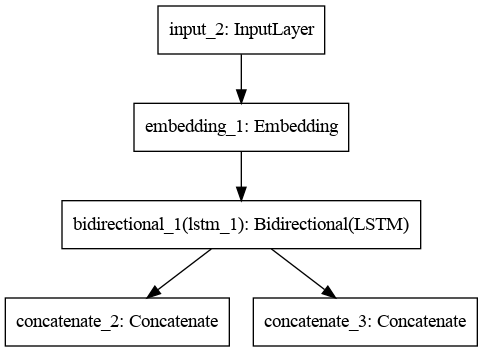

In [5]:
ParEncoder_model.summary()
plot_model(ParEncoder_model, to_file = 'ParEncoder_model.png')

## Generated Sequence Encoder

In [6]:
gen_inputs = Input(shape = (None,4500))
enc_inputsGen = Dense(250, activation = 'linear', use_bias = False)(gen_inputs)
enc_outputsGen, fwd_hGen, fwd_cGen, bwd_hGen, bwd_cGen = enc_BiLSTM(enc_inputsGen)
state_hGen = Concatenate()([fwd_hGen, bwd_hGen])
state_cGen = Concatenate()([fwd_cGen, bwd_cGen])
encoder_stateGen = [state_hGen, state_cGen]
GenEncoder_model = Model([gen_inputs], encoder_stateGen) 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4500)] 0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 250)    1125000     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 256), (None, 388096      dense[0][0]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 256)          0           bidirectional_1[1][1]            
                                                                 bidirectional_1[1][3]      

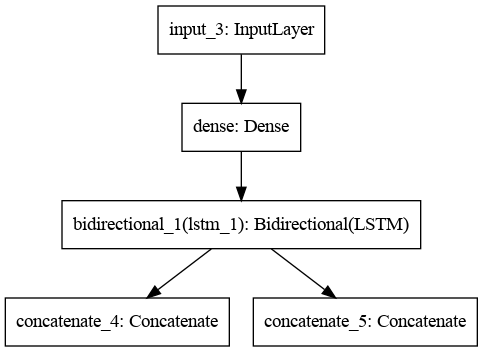

In [7]:
GenEncoder_model.summary()
plot_model(GenEncoder_model, to_file = 'GenEncoder_model.png')

## Load the weights for the pretrained autoencoder

In [ ]:
ParEncoder_model.load_weights('Influenza_biLSTM_encoder_model_128_4500_weights.h5')
GenEncoder_model.layers[1].set_weights(enc_embedding.get_weights()) 

## Discriminator

In [11]:
xPar = ParEncoder_model([par_inputs])
xGen = GenEncoder_model ([gen_inputs])
xConcat = Concatenate()(xPar + xGen)
x = Dropout(0.2)(xConcat)
x = BatchNormalization()(x)
x = Dense(128)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(64)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
output_class = Dense(1, activation = 'linear')(x)
Discriminator = Model([par_inputs, gen_inputs], output_class) 

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 4500)] 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 256), (None, 1513096     input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            [(None, 256), (None, 1513096     input_3[0][0]                    
____________________________________________________________________________________________

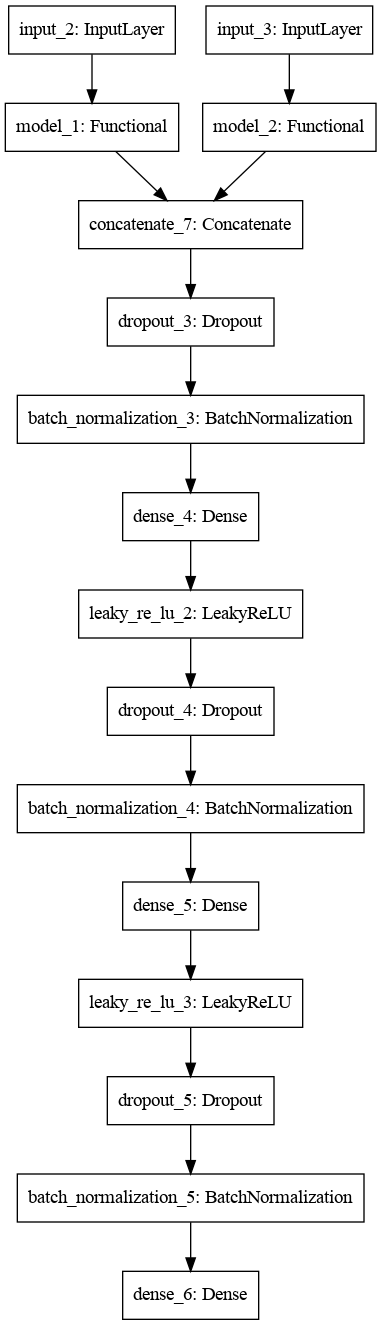

In [12]:
Discriminator.summary()
plot_model(Discriminator, to_file = 'Discriminator.png')

In [ ]:
model.save('path/to/location')